# Simulation of the delivery time of a package under different delay factors
A Open Mini Challlenge  by Mykhailo Andrusiak and Alexis Boser Makaratzis

Modul WER

Springsemester 2025, FHNW/HSI/DS

## 1. Question

### What we want to know:


What is the probability of an in-time delivery of a parcel sent from a German distribution hub to a  node, considering potential delays caused by weather disruptions, labor strikes, and network congestion?


Motivation:
Standard parcel logistics assume a delivery time of one to two working days under normal conditions within Germany. However, disruptions in the delivery chain such as strong weather events, infrastructure congestion during peak shopping periods, and labor strikes can significantly alter this. By simulating these risks, we aim to quantify the likelihood of delay.

---



## 2. System definition

### We assume:

 1. Every parcel is sent from a hub along the same route to the final node.
2. The standard delivery time (not express) is between one and two days under normal conditions. We assume one day and add different delays.
    This assumption is based on data from DHL[^1]. Other private distributors have same or similar delivery times.
3. Hub and node are assumed to be in the same country to avoid international supply chain delays.
4. Parcel characteristics[^6]:

    - Every sent unit is a parcel and not a letter
    - Weights are < 2.0 kg
    - Sizes are over 15 x 11 x 1 and under 120 x 60 x 60 cm



[^1]: https://www.dhl.de/en/privatkunden/pakete-versenden/online-frankieren.html?type=ShipmentEditorProductSelection&tid=hp-teaser-minimodul-pak31

[^2]: https://www.logistikcluster-regionbasel.ch/logistikstandort/facts-figures/die-schweizerischen-rheinhaefen/

[^6]: https://www.dhl.de/en/privatkunden/pakete-versenden/deutschlandweit-versenden/versand-bis-2kg.html

### We do **not** model:

- **Difference in modes of transportation** such as trains, trucks or planes.
- **«Last Mile/ Capillary Deliveries»** from the last node to the final receiver. This exceeds our scope here.
- **«Time of Day» Effects**, such as a business hours and handovers. This exceeds our scope here.
- **All parcel weights and sizes** Oversized and overweight parcels are excluded due to irregular and undefined delivery conditions.
- **Weekdays and weekends.** We are not adjusting to reduced processing speed. Finding and processing this data exceeds our scope.
- **Large scale disruptions** such as pandemics, war scenarios or comparable crisis scenarios. This exceeds our scope here.
- **Queuing effects** building solely on queuing theory models such as M/M/1. Sadly exceeds our scope here.
- **Sensitiviy Testing.**  due to time constraints and the complexity this exceeds our scope here.
- **Scenario comparison**: Impact analysis of individual events or event combinations compared to the baseline scenario.
- **Recovery Mechanisms**: Logisitcal Networks prepare for expected overloads, lessening their effect. Modeling this exceeds our scope here.

---

### Relevant events (“Ereignisse”):

 Package arrives within 2 Days:[^7]		**In time**

 Package arrives after 2 Days:		**delayed**

[^7]: https://www.dhl.de/en/privatkunden/pakete-versenden/deutschlandweit-versenden/versand-bis-2kg.html
---

### Relevant random variables affecting delays:

#### 1. Weather condition variables (independent and dependent):

We model precipitation consisting of Ice, Snow and strong Rain and Wind. Some of these variables are independent, others are not.

| **Weather Event**                                 | **Condition**                                                                                                                                                                                                                                                                                                  | **Interacts With**                                                | **Occurrence / Delay Distribution**                                                    | **Justification**                                                                                                                                                                                                                            |
|---------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------|----------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Heavy Snow**                                    | Occurs if:  <br>- A random number from 0 to 1 is lower than the Probability for heavy snow  <br><br> P (HIGH\_SNOW\_PROB) = 0.05                                                                                                                                                                               | Blocks normal snow and rain <br><br> Part of storm if wind occurs | Bernoulli(0.05) <br> Lognormal(μ=ln(2), σ=0.5)                                         | **Occurrence:** Rare event occurring independently → Bernoulli is appropriate. <br><br> Delay: Models rare but high-impact delays. Lognormal prevents negative delays and allows for long tails.                                             |
| **Normal Snow**                                   | Occurs if:  <br> A random number from 0 to 1 is lower than the Probability for snow (P (SNOW\_PROB) = 0.17) and <br><br> if heavy snow does not occur                                                                                                                                                          | Blocks rain <br><br> Part of storm if wind occurs                 | Conditional Bernoulli <br> Poisson(λ=1)                                                | **Occurrence:** Occurs only if heavy snow doesn't happen. Mutually exclusive → Conditional Bernoulli. <br><br> Delay: Typical snowfall events are low in delay but random; Poisson fits low-count independent events.                        |
| **Strong Rain**                                   | Occurs if:  <br> A random number from 0 to 1 is lower than the Probability for rain (P (STRONG\_RAIN\_PROB) = 0.05) and <br><br> if heavy snow or normal snow does not occur                                                                                                                                   | Part of storm if wind occurs                                      | Conditional Bernoulli <br> Poisson(λ=1)                                                | **Occurrence:** Precipitation fallback if snow fails → Conditional Bernoulli. <br><br> Delay: Like snow, strong rain causes short, stochastic delays; Poisson captures this concisely.                                                       |
| **Wind**                                          | Occurs if:  <br> A random number from 0 to 1 is lower than the Probability for wind (P (WIND\_PROB) = 0.01)                                                                                                                                                                                                    | Part of storm                                                     | Bernoulli(0.01) <br> Triangular(0.5, 0.7, 1.0)                                         | **Occurrence:** Rare spontaneous event → classic Bernoulli. <br><br> Delay: Delays are rare ; triangular reflects most probable values and excludes extremes, as they are modeled in variable STORM.                                         |
| **Regular Ice**<br>And<br>**Ice after high Snow** | Regular Ice Occurs if:  <br> A random number from 0 to 1 is lower than the Probability for Ice (P (ICE\_PROB) = 0.31 ) <br><br> Ice after high Snow occurs if:  <br> High snow occurs and <br> a random number from 0 to 1 is lower than the Probability for Ice after snow (P (ICE\_AFTER\_SNOW\_PROB) = 0.4) | More likely after heavy snow (from P of 0.31 to 0.4)              | Bernoulli + Conditional Bernoulli <br> Truncated Normal(μ=1, σ=0.3, bounds=[0.5, 1.5]) | **Occurrence:** Can occur independently or as conditional follow-up → Combined Bernoulli model. <br><br> Delay: Ice is more likely after snow; truncated normal allows variability but enforces realistic delay bounds.                      |
| **Storm**                                         | Occurs if:  <br> Wind AND (rain OR normal snow OR heavy snow) occur                                                                                                                                                                                                                                            | Overrides individual delays of wind, rain, and both snows         | Derived composite <br> Truncated Normal(μ=4, σ=0.5, bounds=[3, 6])                     | **Occurrence:** Built from logical conjunction of other variables, not sampled directly. <br><br> Delay: Storms emerge from multiple events; delay is explicitly modeled with bounded normal distribution to reflect typical storm duration. |






**Sources:**

[Weather data (ECA&D)](https://www.ecad.eu/indicesextremes/customquerytimeseriesplots.php?optionSelected=country&processtext1=Your+query+is+being+processed.+Please+wait...&countryselect=SWITZERLAND%7Cch&stationselect=All+stations%7C**&categoryselect=All+categories%7C**&indexselect=All+indices%7C**&seasonselect=ANNUAL%7C0&processtext2=Your+query+is+being+processed.+Please+wait...)

*To obtain the required data, select the relevant parameters such as **Index** and **Country** on the ECA&D custom query page.*

**Note:**  
For this OMC, we used data from Switzerland to streamline the data collection process. We made a seperate script to aggregate the needed data (utils/parse_weather_data.py).  Downloading equivalent datasets for Germany would require more than 15,000 manual downloads, making it impractical within the project scope.

---

#### 2. Strikes in the transport sector (independent variable)

***Strike-Based Delay Model Summary (Germany, 2014–2024)***
Due to the absence of relevant strikes in Switzerland during 2014–2024, we shifted our scope to Germany, where logistic-related strikes are more frequent. We focused on strikes affecting:

- Seaports
- Air cargo
- Rail freight
- Postal services


We collected strike events in a data table across a timespan of ten years and applied the following assumptions:

**Unit of Observation:** Each strike counts as one occurrence, regardless of duration.

**Split Events:** Disjointed periods of the same strike were counted separately.

**Duration Binning:**

Short Strikes: ≤ 3 days

Long Strikes: > 3 days

This yielded:

| **Strike Category** | **Definition**          | **Occurrences** | **Probability** | **Avg. Delay (days)** | **Occurrence / Delay Distribution**                                  | **Justification**                                                                                                                                                                     |
|---------------------|--------------------------|------------------|------------------|------------------------|------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Short Strike**    | Strike lasting ≤ 3 days  | 19               | 0.0052           | 1.61                   | Bernoulli(0.0052) <br> Truncated Normal(μ=1.6, σ=0.5, bounds=[0.5, 3]) | **Occurrence:** Modeled via Bernoulli based on historical rate. <br><br> **Delay:** Short strikes show limited variance → truncated normal prevents negatives and overestimation.     |
| **Long Strike**     | Strike lasting > 3 days  | 5                | 0.0014           | 8.6                    | Bernoulli(0.0014) <br> Lognormal(μ=ln(8.6), σ=0.5)                     | **Occurrence:** Rare but documented → Bernoulli with low p. <br><br> **Delay:** Long strikes have high variability and skew → lognormal captures tail risk while remaining positive. |


**Sources:** All individual strikes are backed by sources. For detailed information look at the table utils/germany_strikedata.xlsx.

---

#### 3. Overload  in the logistic networks

To capture delays caused by overloaded distribution hubs, we introduced congestion as a third variable. We distinguish:

**Independent congestion** (e.g., Christmas season spikes)

**Dependent congestion** (e.g., post-weather-event backlogs)

While we initially explored queuing theory (e.g., M/M/1 model), implementing it would require a secondary model beyond our Monte Carlo framework — exceeding the scope of this project. As a result, we opted for a simplified structure using subvariables to represent both types of congestion.

---

##### 3.1 Independent network congestion variable


We simulate regular seasonal overloads at distribution hubs during peak demand periods in germany.
This occurs when the arrival rate of parcels exceeds the service rate per given time interval:

- **Weeks 47–52**: Pre-Christmas shopping (e.g., Black Friday, Cyber Monday) [^3]
- **Week 1**: Post-holiday returns and New Year sales [^4]

These **6 weeks** represent periods of elevated parcel volume and increased network strain.

**Calculated probability**:
- INDEPENDENT_CONGESTION_PROB = 6 / 52 ≈ 0.1153 ≈ 0.12

**Assumed delay**:
- No precise data available → assumed delay of **1–2 days**

| **Event**               | **Occurrence / Delay Distribution**                                  | **Justification**                                                                                                                                                                     |
|------------------------|------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Independent Congestion | Bernoulli(p=0.12) <br> Truncated Normal(μ=1.5, σ=0.5, bounds=[0.5, 3]) | **Occurrence:** Based on 6 out of 52 calendar weeks → estimated Bernoulli with p = 0.12. <br><br> **Delay:** No empirical data available → truncated normal avoids overestimation and bounds plausible delays realistically. |




[^3]: https://ecommercenews.eu/dhl-hikes-parcel-rates-in-peak-season/

[^4]: https://www.fulfillmenteurope.com/other/seasonal-peaks/

---

##### 3.2 Dependent network congestion variable


Some congestion events are not seasonal but occur **as a consequence of other disruptions**, such as weather events or strikes. These **dependent congestions** reflect the **secondary strain** on logistics networks — for example, backlog buildup after a snowstorm or delayed rerouting during a strike.

We model this with conditional probabilities: each disruptive event has a likelihood of causing follow-up congestion, as shown below.


| **Event**               | **Occurrence / Delay Distribution**                                                | **Justification**                                                                                                                                                                                                                         |
|-------------------------|-------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Dependent Congestion** | Conditional Bernoulli (p varies by trigger event) <br> Lognormal(μ=ln(2), σ=0.6)  | **Occurrence:** Triggered by other disruptions (e.g., weather, strikes), each with a specific conditional probability. Expert-estimated due to lack of hard data. <br><br> **Delay:** Congestion builds additively. Lognormal models skewed delays realistically with positive-only support and moderate tail risk. |

**Conditional Probabilities for Triggered Congestion**:

| **Trigger Event**  | **Probability** |
|--------------------|-----------------|
| Wind               | 0.05            |
| Strong Rain        | 0.05            |
| Snow               | 0.05            |
| Heavy Snow         | 0.1             |
| Ice                | 0.1             |
| Short Strike       | 0.3             |
| Long Strike        | 0.5             |




**Assumed delay**:
For all dependent congestion cases, we assume a delay of 1–3 days.
Looking at the data, this range is on the lower end [^5]. But as we already account for the delay caused by the conditional event, we opted for this range.



**Sources**: We could not find data in a reasonable timeframe and therefore made our best realistic and conservative estimates.



[^5]: https://www.railfreight.com/business/2024/06/20/weather-becomes-a-delaying-factor-for-german-rail-again/

---

## 3. Solution Strategy

### Basis for Modeling Probabilities

The probabilities of disruption events  are modeled based on the following sources:

- **Data sources:** Wherever we used publicly available data, footnotes link to the sources. We always aimed for the most direct and reliable source. If that is not the case, then because we could not find any other.
- **Assumptions:** For events lacking sufficient data, realistic and conservative estimates are made based on our best assumptions. Whenever we made assumptions, we clearly stated it.


---

### Method for Modeling Probabilities


**Independent events**  are modeled mostly using **Bernoulli distributions** with fixed occurrence probabilities.

**Dependent events**  are modeled using **different fitting probabilities**.

---

### Method for Answering the Research Question

The research question is addressed using a Monte Carlo simulation. A sufficiently large number of simulations are run (N_SIMULATIONS = 200000). Monte Carlo simulation is ideal for this study as it handles interacting uncertainties and reveals the full distribution of delivery outcomes. Unlike hypothesis testing, which requires strict assumptions and yields binary results.

Our steps in the model are:

- Relevant disruption events are triggered randomly according to their probabilities.

- The resulting delivery delays are aggregated.

- The model is run 5 consecutive times to establish convergence.

- The total delivery times are statistically analyzed.

- The result is contextualized and commented to make statements about the distribution of delivery times and to assess the risk of significant delays



---

### Evaluation Strategy

The simulation results will be analyzed as follows:

- Descriptive statistics: Mean, median, variance, and percentiles of delivery duration.

- Visualization: Histograms and cumulative density plots of delivery times.

---








## Probability Modell

### Simulation Parameters


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import truncnorm, lognorm, triang

In [3]:
# Simulation Parameters
N_SIMULATIONS = 200000  # Number of packages simulated
BASE_DELIVERY_TIME = 1  # 1 to 2 Days under normal conditions. Used lower bound to add presumed delays in DHL caluclation

#-----------------------------------------------------------------------------------------

# Weather Parameters
# Wheather delays will be randomly assigned as we don't have a specific data
# Rest of the parameter based on the real data 

#WIND
WIND_PROB = 0.01
# DELAY: Triangular distribution: min=0.5, mode=0.7, max=1.0
WIND_DELAY = triang.rvs(c=(0.7 - 0.5) / (1.0 - 0.5), loc=0.5, scale=0.5, size=N_SIMULATIONS)

#STRONG RAIN
STRONG_RAIN_PROB = 0.05  
# DELAY: Poisson-distributed delay with mean = 1
STRONG_RAIN_DELAY = np.random.poisson(lam=1, size=N_SIMULATIONS)

#SNOW
SNOW_PROB = 0.17
# DELAY: Poisson-distributed delay with mean = 1
SNOW_DELAY = np.random.poisson(lam=1, size=N_SIMULATIONS)

#HIGH SNOW
HIGH_SNOW_PROB = 0.05 
# DELAY: Lognormal: mean≈2, std dev≈0.5 in log-space
HIGH_SNOW_DELAY = lognorm(s=0.5, scale=np.exp(np.log(2))).rvs(N_SIMULATIONS)

#STORM
# DELAY: Truncated normal: mean=4, std dev=0.5, bounds=[3, 6]
storm_a, storm_b = (3 - 4) / 0.5, (6 - 4) / 0.5
STORM_DELAY = truncnorm(storm_a, storm_b, loc=4, scale=0.5).rvs(N_SIMULATIONS)

#ICE
ICE_PROB = 0.31
ICE_AFTER_SNOW_PROB = 0.4
# DELAY: Truncated normal: mean=1, std dev=0.3, bounds=[0.5, 1.5]
ice_mean, ice_std = 1, 0.3
ice_a, ice_b = (0.5 - ice_mean) / ice_std, (1.5 - ice_mean) / ice_std
ICE_DELAY = truncnorm(ice_a, ice_b, loc=ice_mean, scale=ice_std).rvs(N_SIMULATIONS)

#-----------------------------------------------------------------------------------------

# Strike Parameter
# Probability and delay are beforehand calculated from real world data.


# SHORT STRIKE of length of 0 to 3 days
SHORT_STRIKE_PROB = 0.0052
# DELAY: Truncated normal: mean=1.61, std dev=0.5, bounds=[0.5, 3]
short_a, short_b = (0.5 - 1.61) / 0.5, (3 - 1.61) / 0.5
SHORT_STRIKE_DELAY = truncnorm(short_a, short_b, loc=1.61, scale=0.5).rvs(N_SIMULATIONS)

# LONG STRIKE of length of more than 3 days
LONG_STRIKE_PROB = 0.0014
# DELAY: Lognormal: mean≈8.6, std dev=0.5 in log-space
LONG_STRIKE_DELAY = lognorm(s=0.5, scale=np.exp(np.log(8.6))).rvs(N_SIMULATIONS)


#-----------------------------------------------------------------------------------------

# Network Congestion Parameter

# Independent Network Congestions
INDEPENDENT_CONGESTION_PROB = 0.12
# DELAY: Truncated normal: mean=1.5, std dev=0.5, bounds=[0.5, 3]
ind_mean, ind_std = 1.5, 0.5
ind_a, ind_b = (0.5 - ind_mean) / ind_std, (3 - ind_mean) / ind_std
INDEPENDENT_CONGESTION_DELAY = truncnorm(ind_a, ind_b, loc=ind_mean, scale=ind_std).rvs(N_SIMULATIONS)

# Dependent Network Congestions (conditional on specific weather or strike events)
CONGESTION_PROB_WIND = 0.05
CONGESTION_PROB_STRONG_RAIN = 0.05
CONGESTION_PROB_SNOW = 0.05
CONGESTION_PROB_HIGH_SNOW = 0.1
CONGESTION_PROB_ICE = 0.1
CONGESTION_PROB_SHORT_STRIKE = 0.3
CONGESTION_PROB_LONG_STRIKE = 0.5
# DELAY: Lognormal: mean≈2, std dev=0.4 in log-space
DEPENDENT_CONGESTION_DELAY = lognorm(s=0.4, scale=np.exp(np.log(2))).rvs(N_SIMULATIONS)


In [4]:
# Monte Carlo Simulation
def simulate_delivery():
    delays = np.zeros(N_SIMULATIONS)  # Initialize delays array of length N_SIMULATIONS filled with zeros

#-----------------------------------------------------------------------------------------

    # Weather Simulation


    # --- Heavy snow and normal snow (mutually exclusive) ---
    # Simulates whether heavy snow occurs for each parcel (True for ~5% if HIGH_SNOW_PROB = 0.05)
    high_snow_occurs = np.random.rand(N_SIMULATIONS) < HIGH_SNOW_PROB
    # Adds heavy snow delay only to parcels where heavy snow occurred
    # (Numpy lets True become 1, so only affected parcels receive a delay from HIGH_SNOW_DELAY array)
    delays += high_snow_occurs * HIGH_SNOW_DELAY


    # --- Normal snow occurs only if heavy snow did not occur ---
    snow_occurs = (np.random.rand(N_SIMULATIONS) < SNOW_PROB) & (~high_snow_occurs)
    delays += snow_occurs * SNOW_DELAY


    # --- Rain and snow (mutually exclusive approximation) ---
    # Only rain if snow (normal or heavy) did not happen
    rain_occurs = (np.random.rand(N_SIMULATIONS) < STRONG_RAIN_PROB) & (~snow_occurs) & (~high_snow_occurs)
    delays += rain_occurs * STRONG_RAIN_DELAY

    # --- Ice: can occur independently, but more likely after heavy snow ---
    base_ice_occurs = np.random.rand(N_SIMULATIONS) < ICE_PROB
    conditional_ice_after_snow = high_snow_occurs & (np.random.rand(N_SIMULATIONS) < ICE_AFTER_SNOW_PROB)
    ice_occurs = base_ice_occurs | conditional_ice_after_snow
    delays += ice_occurs * ICE_DELAY

    # --- Wind (independent) ---
    wind_occurs = np.random.rand(N_SIMULATIONS) < WIND_PROB
    delays += wind_occurs * WIND_DELAY

    # --- Storm event (combined wind + rain or snow) replaces individual delays if occurred ---
    storm_occurs = wind_occurs & (rain_occurs | snow_occurs | high_snow_occurs)
    delays[storm_occurs] -= (wind_occurs * WIND_DELAY + rain_occurs * STRONG_RAIN_DELAY + snow_occurs * SNOW_DELAY + high_snow_occurs * HIGH_SNOW_DELAY)[storm_occurs]
    delays[storm_occurs] += STORM_DELAY[storm_occurs]




#-----------------------------------------------------------------------------------------

    #Strike Simulation

    # --- Strikes: only one type of strike can happen at a time ---
    strike_randoms = np.random.rand(N_SIMULATIONS)
    long_strike_occurs = strike_randoms < LONG_STRIKE_PROB
    short_strike_occurs = (strike_randoms < SHORT_STRIKE_PROB) & (~long_strike_occurs)

    delays += long_strike_occurs * LONG_STRIKE_DELAY
    delays += short_strike_occurs * SHORT_STRIKE_DELAY

#-----------------------------------------------------------------------------------------

    #Network Congestion Simulation

    # --- Independent congestion ---
    independent_congestion_occurs = np.random.rand(N_SIMULATIONS) < INDEPENDENT_CONGESTION_PROB
    delays += independent_congestion_occurs * INDEPENDENT_CONGESTION_DELAY

    # --- Dependent congestion (separate probabilities for each event) ---
    dependent_congestion_occurs = (
        (wind_occurs & (np.random.rand(N_SIMULATIONS) < CONGESTION_PROB_WIND)) |
        (rain_occurs & (np.random.rand(N_SIMULATIONS) < CONGESTION_PROB_STRONG_RAIN)) |
        (snow_occurs & (np.random.rand(N_SIMULATIONS) < CONGESTION_PROB_SNOW)) |
        (high_snow_occurs & (np.random.rand(N_SIMULATIONS) < CONGESTION_PROB_HIGH_SNOW)) |
        (ice_occurs & (np.random.rand(N_SIMULATIONS) < CONGESTION_PROB_ICE)) |
        (short_strike_occurs & (np.random.rand(N_SIMULATIONS) < CONGESTION_PROB_SHORT_STRIKE)) |
        (long_strike_occurs & (np.random.rand(N_SIMULATIONS) < CONGESTION_PROB_LONG_STRIKE))
    )
    delays += dependent_congestion_occurs * DEPENDENT_CONGESTION_DELAY






#-----------------------------------------------------------------------------------------

    # --- Total delivery time ---

# Calculate total delivery time by adding base delivery time to individual delays
# NumPy automatically broadcasts the scalar BASE_DELIVERY_TIME (e.g. 2) to all 1,000,000 parcels
# Then performs element-wise addition: total_delivery_time[i] = BASE_DELIVERY_TIME + delays[i]
    total_delivery_time = BASE_DELIVERY_TIME + delays

# Return the array of total delivery times for all simulated parcels
# Each value represents how long a parcel took to be delivered, including any delays
    return total_delivery_time


---

### Simulation execution



In [5]:
# Run 5 independent simulations
all_results = []
all_delivery_times = []
for i in range(5):
    delivery_times = simulate_delivery()
    stats = {
        "mean": np.mean(delivery_times),
        "median": np.median(delivery_times),
        "std": np.std(delivery_times),
        "prob_under_2": np.mean(delivery_times < 2),
        "prob_under_3": np.mean(delivery_times < 3),
        "prob_over_5": np.mean(delivery_times > 5),
        "prob_over_10": np.mean(delivery_times > 10),
    }
    all_results.append(stats)
    all_delivery_times.append(delivery_times)

---
### Statistical Analysis and Visualisation

In [6]:
# Disage statistics for each simulation separately
for i, stats in enumerate(all_results):
    print(f"Simulation {i+1}:")
    print(f"  Mean: {stats['mean']:.2f}, Median: {stats['median']:.2f}, Std: {stats['std']:.2f}")
    print(f"  <2d: {stats['prob_under_2']:.2%}, <3d: {stats['prob_under_3']:.2%}, >5d: {stats['prob_over_5']:.2%}, >10d: {stats['prob_over_10']:.2%}")
    print("-" * 40)

# The total resume on all simulations
means = [r["mean"] for r in all_results]
medians = [r["median"] for r in all_results]
stds = [r["std"] for r in all_results]
prob_under_2 = [r["prob_under_2"] for r in all_results]
prob_under_3 = [r["prob_under_3"] for r in all_results]
prob_over_5 = [r["prob_over_5"] for r in all_results]
prob_over_10 = [r["prob_over_10"] for r in all_results]

print("=== Summary across 5 simulations ===")
print(f"Mean: {np.mean(means):.2f} ± {np.std(means):.2f}")
print(f"Median: {np.mean(medians):.2f} ± {np.std(medians):.2f}")
print(f"Std: {np.mean(stds):.2f} ± {np.std(stds):.2f}")
print(f"<2d: {np.mean(prob_under_2):.2%}")
print(f"<3d: {np.mean(prob_under_3):.2%}")
print(f">5d: {np.mean(prob_over_5):.2%}")
print(f">10d: {np.mean(prob_over_10):.2%}")


Simulation 1:
  Mean: 1.96, Median: 1.60, Std: 1.37
  <2d: 60.15%, <3d: 81.87%, >5d: 3.78%, >10d: 0.14%
----------------------------------------
Simulation 2:
  Mean: 1.96, Median: 1.59, Std: 1.37
  <2d: 60.41%, <3d: 82.04%, >5d: 3.72%, >10d: 0.14%
----------------------------------------
Simulation 3:
  Mean: 1.96, Median: 1.59, Std: 1.37
  <2d: 60.35%, <3d: 81.99%, >5d: 3.71%, >10d: 0.14%
----------------------------------------
Simulation 4:
  Mean: 1.96, Median: 1.58, Std: 1.37
  <2d: 60.46%, <3d: 81.94%, >5d: 3.78%, >10d: 0.13%
----------------------------------------
Simulation 5:
  Mean: 1.96, Median: 1.59, Std: 1.37
  <2d: 60.43%, <3d: 81.94%, >5d: 3.75%, >10d: 0.13%
----------------------------------------
=== Summary across 5 simulations ===
Mean: 1.96 ± 0.00
Median: 1.59 ± 0.01
Std: 1.37 ± 0.00
<2d: 60.36%
<3d: 81.96%
>5d: 3.75%
>10d: 0.14%


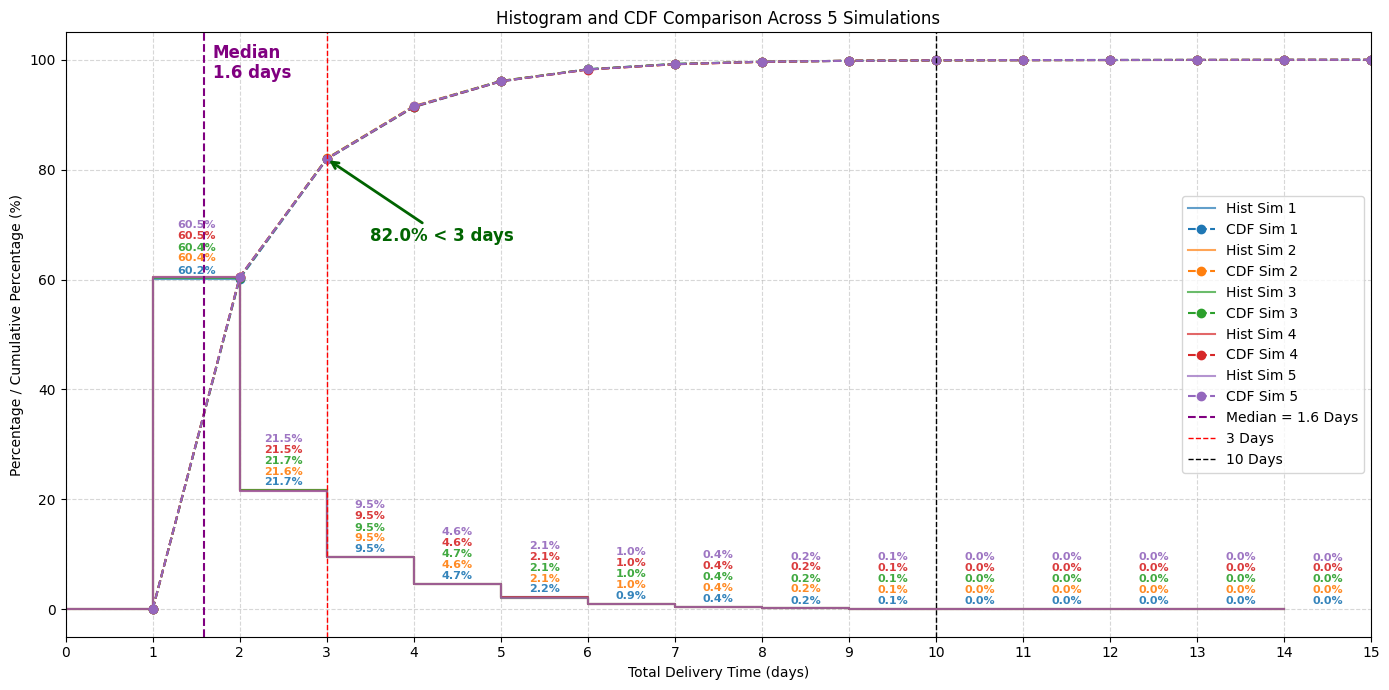

In [7]:
# Create a new figure with a specified size
plt.figure(figsize=(14, 7))

# Fixed bin range: 0 to 20 days
MAX_DAY = 15
bins = np.arange(0, MAX_DAY + 1)

colors = plt.cm.tab10.colors  # Use a colormap for different simulations
offset_step = 2  # Offset for percentage labels to avoid overlap

medians = []  # Store medians for each simulation
cdf3s = []    # Store CDF values at 3 days for each simulation

# Loop through each simulation's delivery times
for i, delivery_times in enumerate(all_delivery_times):
    color = colors[i % len(colors)]

    counts, bin_edges = np.histogram(delivery_times, bins=bins)
    percentages = counts / counts.sum() * 100

    # Plot histogram as a step plot for each simulation
    plt.step(bins[:-1], percentages, where='post', label=f'Hist Sim {i+1}', alpha=0.7, color=color)

    # Add percentage labels above each histogram bin
    for j, (x, y) in enumerate(zip(bins[:-1], percentages)):
        if y > 0:
            plt.text(
                x + 0.5,
                y + 0.5 + i * offset_step,
                f'{y:.1f}%',
                ha='center', va='bottom',
                fontsize=8,
                color=color,
                alpha=0.9,
                fontweight='bold'
            )

    # Calculate and plot the cumulative distribution function (CDF)
    cdf = np.cumsum(percentages)
    cdf[-1] = 100  # Ensure the last value is exactly 100%
    plt.plot(bins[1:], cdf, marker='o', linestyle='--', label=f'CDF Sim {i+1}', color=color)

    # Save median and CDF at 3 days for summary statistics
    medians.append(np.median(delivery_times))
    cdf3 = cdf[bins[1:] == 3][0] if 3 in bins[1:] else np.nan
    cdf3s.append(cdf3)

# Draw a vertical line for the average median across all simulations
median_val = np.mean(medians)
plt.axvline(median_val, color='purple', linestyle='--', linewidth=1.5, label=f'Median = {median_val:.1f} Days')
plt.text(median_val + 0.1, plt.ylim()[1]*0.92, f'Median\n{median_val:.1f} days', color='purple', fontsize=12, fontweight='bold')

# Annotate the average percentage of deliveries ≤ 3 days with a green arrow
mean_cdf3 = np.nanmean(cdf3s)
plt.annotate(f'{mean_cdf3:.1f}% < 3 days',
             xy=(3, mean_cdf3),
             xytext=(3.5, mean_cdf3 - 15),
             arrowprops=dict(arrowstyle='->', color='darkgreen', lw=2),
             fontsize=12, color='darkgreen', ha='left', fontweight='bold')

# Set axis labels and title
plt.xlabel('Total Delivery Time (days)')
plt.ylabel('Percentage / Cumulative Percentage (%)')
plt.title('Histogram and CDF Comparison Across 5 Simulations')

# Add vertical lines for 3 days (red) and 10 days (black) as reference
plt.axvline(3, color='red', linestyle='dashed', linewidth=1, label='3 Days')
plt.axvline(10, color='black', linestyle='dashed', linewidth=1, label='10 Days')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Set x-axis ticks and limit from 0 to 20 days
plt.xticks(bins)
plt.xlim(0, MAX_DAY)

plt.tight_layout()
plt.show()





---

### Interpretation

The histogram shows the distribution of simulated parcel delivery times. The peak at 2 days reflects the baseline, while longer delivery times result from modeled disruptions such as snow, strikes, or congestion. Frequencies drop off rapidly, and the red dashed line at 3 days marks a soft threshold for acceptable delivery.

The system performs well under ideal conditions but shows high sensitivity to combined disruptions, indicating insufficiencies. Only around 82 % of parcels arrive untill 3 days.

In addition to the overall median of around 1.6 days, the five independent simulations show almost identical results: the share of deliveries < 3 days ranges from 81.9% to 82.1%. This indicates model convergence and robustness against stochastic fluctuations.


---
### Critical Reflection and Contextualisation

In Germany, the following regulation applies:
> *"Von den an einem Werktag eingelieferten inländischen Paketen müssen im Jahresdurchschnitt mindestens 80 vom Hundert bis zum zweiten auf den Einlieferungstag folgenden Werktag ausgeliefert werden."* [^9]

-Post-Universaldienstleistungsverordnung, 1999

We now compare our simulation results to recent performance data:

- **2024**: DHL reported a parcel delivery punctuality of **95.7%**.
  *Note: This figure reflects global operations and is not specific to parcel type.* [^8]

- **July 2021 – June 2022**:
  The minimum quota of 80% was met across **all national delivery zones (Leitzonen)**.
  The **lowest punctuality** was recorded in Zone 2 (Mecklenburg-Vorpommern and parts of Lower Saxony and Brandenburg) at **95.3%**. The **national average is 96.23%**. [^10]


Based on this, both DHL and the Bundesnetzagentur report parcel punctuality rates between **95.3% and 96.2%**.
In contrast, our simulation yields an on-time delivery rate of **only around 82%**, indicating deviations of:

- **13.3 percentage points** from DHL’s global figure, and
- **14.2 percentage points** from the Bundesnetzagentur's national average.

When compared to the **legal minimum requirement of 80%**, our model overperforms by **2 percentage points**.

This significant deviation suggests that the simulation likely **overestimates the frequency and/or severity of delays**, or omits key real-world logistics mechanisms.
Notably, **recovery mechanisms** (such as rerouting, weekend surge processing, or overtime operations) were **not part of the model**, but could be included in a future iteration to improve realism.

The simulation was conducted using a **Monte Carlo approach with 200,000 iterations which was run 5 times**, capturing a wide range of random event combinations and their cumulative impact on delivery time.

---

### Suggested Next Steps

- **Model Recovery Mechanisms**: Introduce operational flexibility (e.g. surge capacity, backlog clearing) to reflect how real logistics networks manage disruptions.

- **Sensitivity Testing**:
  Explore which assumptions (e.g. snow frequency, strike duration) have the greatest impact on delivery outcomes.

- **Scenario Comparison**:
  Analyze the **isolated and combined effects** of specific events (e.g. heavy snow + strike) compared to the baseline.
  This would support a more granular understanding of risk dynamics within the system.













[^8]: https://group.dhl.com/content/dam/deutschepostdhl/en/media-center/investors/documents/annual-reports/DHL-Group-2024-Annual-Report.pdf (page 15)
[^9]: https://www.post-und-telekommunikation.de/PuT/1Fundus/Dokumente/PUDLV99_Fassung_2.G.AendPostG.pdf
[^10]: https://www.bundesnetzagentur.de/SharedDocs/Downloads/DE/Sachgebiete/Post/Verbraucher/Qualitaetsmonitoring/studiepaketlaufzeit.pdf?__blob=publicationFile&v=1 (page 17)

